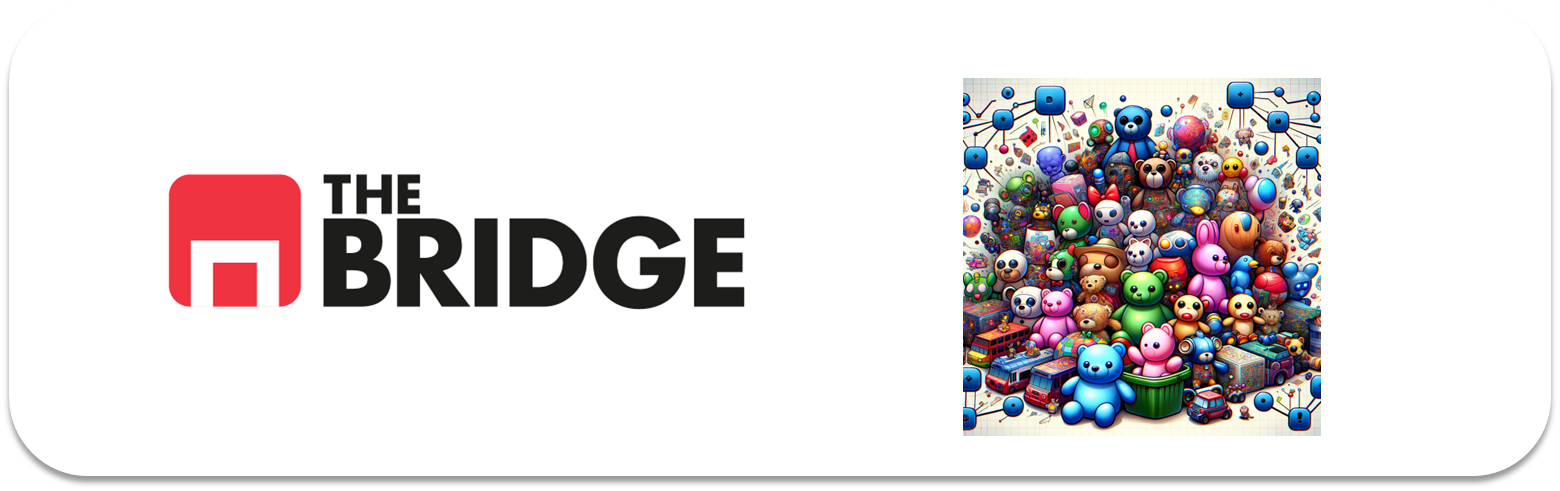

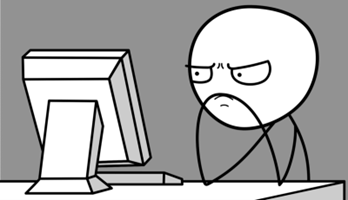

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as shc

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import vizdatatools as viz

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es especulativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


### Problema

Es un problema de clusterización (no supervisado). Voy a emplear un DBSCAN y una aproximación aglomeratica (que además debería resultar bien porque como veremos a continuación el set no es muy extenso).

### Cargar datos

In [2]:
train_set = pd.read_csv('./data/empowering_drinks.csv', sep='|')
train_set.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [3]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [4]:
train_set.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


Aquí no hay separación entre train y test porque no hay un target conocido,

Del análisis numérico de las columnas se puede ver que ya están prácticamente estandarizadas (valor medio 0 y deviación 1), así que probablemente podamos ahorrar ese paso.

### Mini-EDA

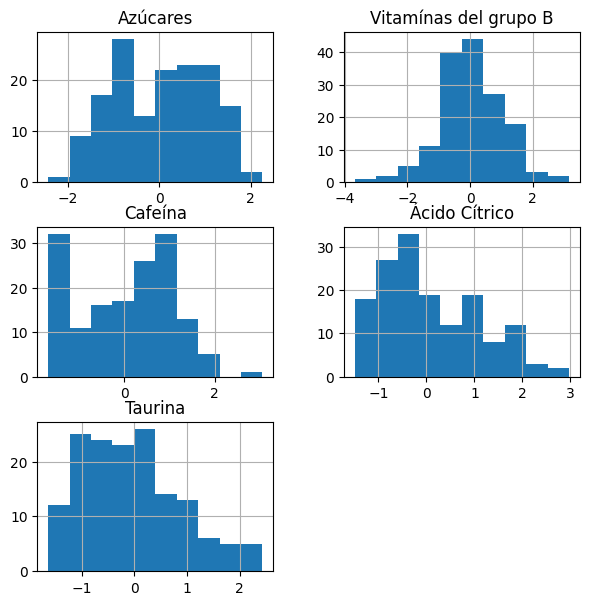

In [5]:
# Histogramas de las features
train_set.hist(figsize=(7, 7));


En el análisis univariante la distribución de las features tienen una forma bastante conveniente. Tal vez "cafeina" se podría transformar, pero como los datos nos los han dado ya estandarizadas no voy a tocarla.


In [6]:
for n_components in np.arange(0.83, 1.0, 0.02):
    pca = PCA(n_components=n_components)
    train_pca = pca.fit_transform(train_set)
    print(f'n_components={n_components}: {pca.n_components_} estimated number of components.')


n_components=0.83: 3 estimated number of components.
n_components=0.85: 3 estimated number of components.
n_components=0.87: 3 estimated number of components.
n_components=0.89: 4 estimated number of components.
n_components=0.91: 4 estimated number of components.
n_components=0.93: 4 estimated number of components.
n_components=0.9500000000000001: 5 estimated number of components.
n_components=0.9700000000000001: 5 estimated number of components.
n_components=0.9900000000000001: 5 estimated number of components.


Para mantener el 95% de la información tengo que conservar las 5 features numéricas.

Como no son tantas columnas (5), voy a hacer un pairplot y evaluar por parejas, y a ojo si encuentro relaciones (o todo lo contrario entre features).

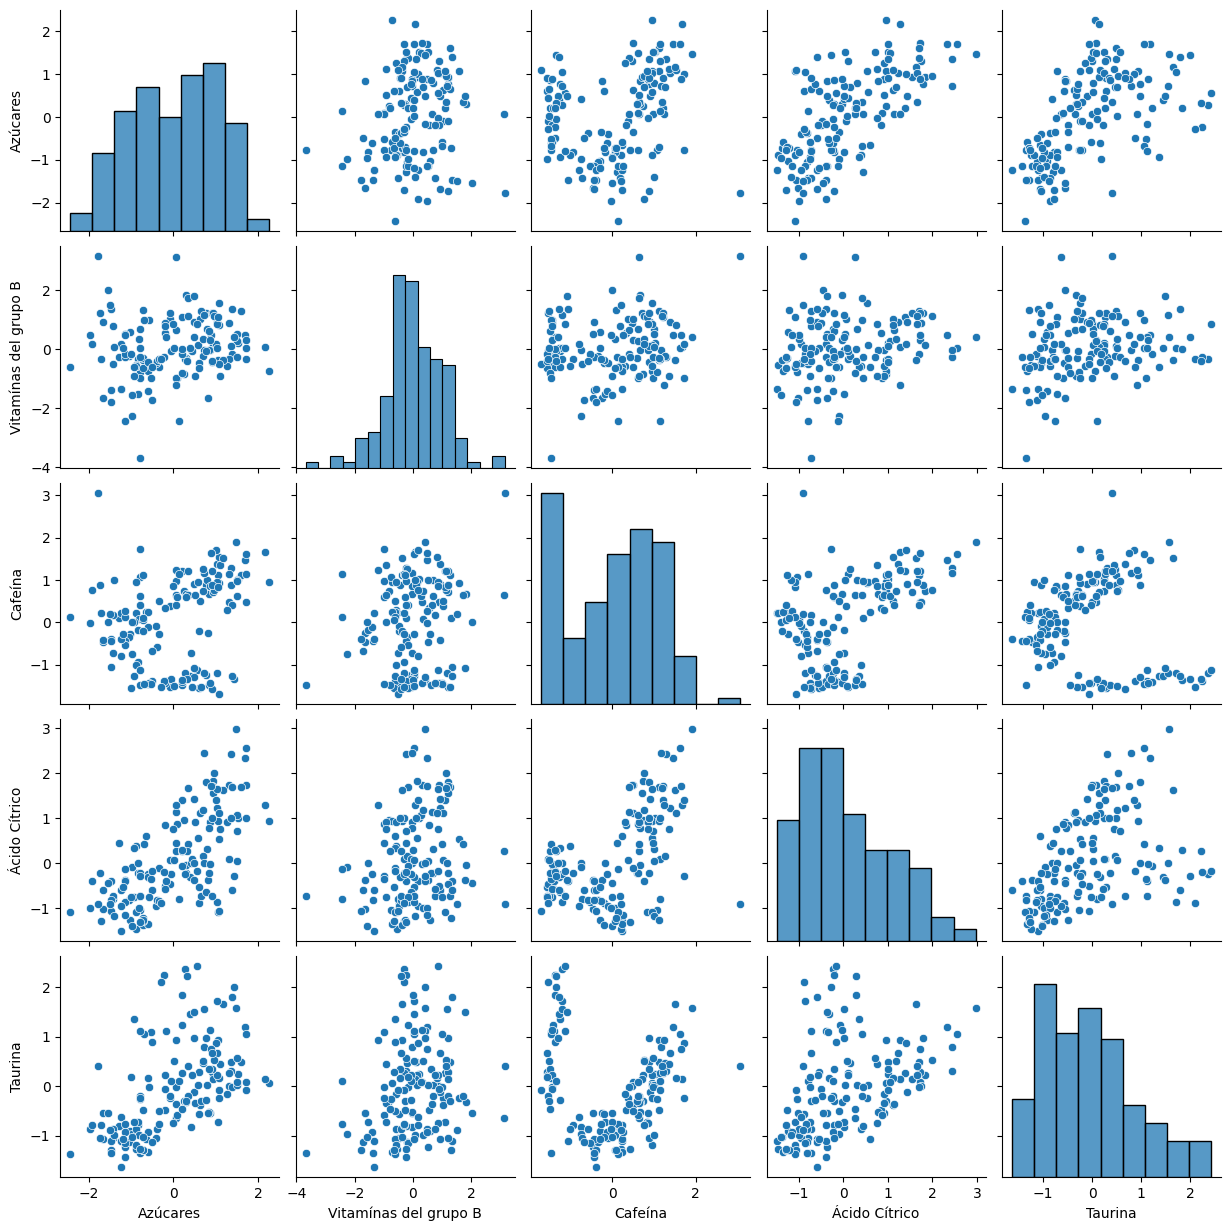

In [7]:
sns.pairplot(train_set)

Un poco de conocimiento de negocio (apoyado con ChatGPT):

- Azúcares: fuente inmediata de energía para el cuerpo
- Cafeina: estimulante del sistema nervioso central
- Las vitaminas del grupo B ayudan a mantener niveles de energía sostenibles, pero no generan un aumento inmediato de energía como los azúcares o la cafeína.
- Ácido cítrico contribuye indirectamente a la producción de energía, pero actúa como conservante y potenciador del sabor.
- La taurina puede mejorar el rendimiento deportivo y cognitivo cuando se combina con cafeína, aunque su mecanismo exacto aún no está completamente claro.

Encuentro zonas de alta densidad cuando evaluo las parejas dos a dos. Por ejemplo en esta selección

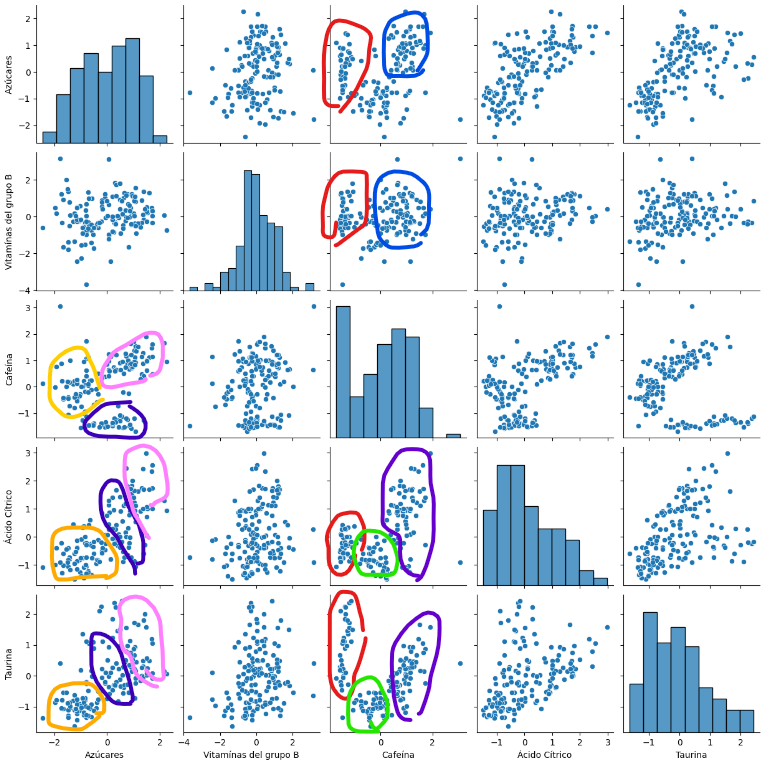

A ojo coincido con los químicos en que podría encontrar 3 clusteres. Más no lo veo claro, pero comprobaré si aparecen 4 o 5 también para el DBSCAN.

### Tratamiento features

Me voy a quedar con todas las features y no voy a hacer ningún tratamiento especial por todo lo que he comentado arriba.

### Modelo DBSCAN

En el caso de los modelos no supervisados, una vez hemos tratado las features hay que escoger los hiperparámetros. En el caso de DBSCAN no es el número de clústeres, sino la distancia `eps` que determina el vecindario de un punto y el número de vecinos a partir del cual se decide si una instancia es core o no (`min_samples`). 

Una forma de hacerlo es iterar sobre rangos de estos dos hiperparámetros midiendo el porcentaje de "anomalías" que detecta y considerando como punto de parada un valor por debajo del 10%.

NOTA: Usa el doble de cantidad de tus features para el mínimo de elementos.

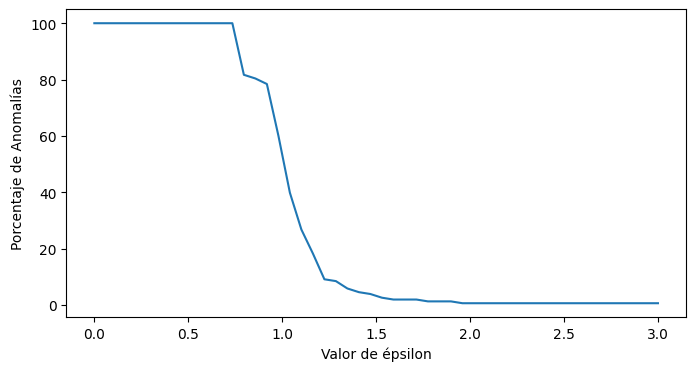

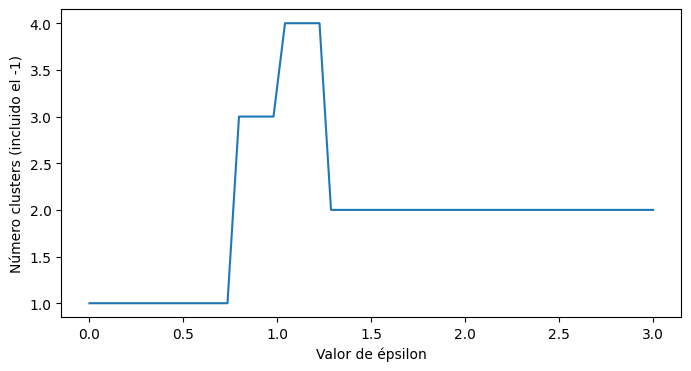

In [8]:
outlier_percent = []
num_labels = []

for eps in np.linspace(0.001, 3, 50):
    dbscan = DBSCAN(eps=eps, min_samples=2*train_set.shape[1]) 
    dbscan.fit(train_set)
     
    # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
    outlier_percent.append(100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_))
    
    # Registramos el número de clusters (contando la etiqueta -1, que no pertenece a ningún cluster)
    num_labels.append(len(np.unique(dbscan.labels_)))
    
#Vamos a pintar ahora el porcentaje de anomalías vs el valor de eps probado
plt.figure(figsize=(8, 4), dpi=100)
sns.lineplot(x=np.linspace(0.001, 3, 50), y=outlier_percent)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.show()

#Vamos a pintar ahora el porcentaje de anomalías vs el valor de eps probado
plt.figure(figsize=(8, 4), dpi=100)
sns.lineplot(x=np.linspace(0.001, 3, 50), y=num_labels)
plt.ylabel("Número clusters (incluido el -1)")
plt.xlabel("Valor de épsilon")
plt.show()

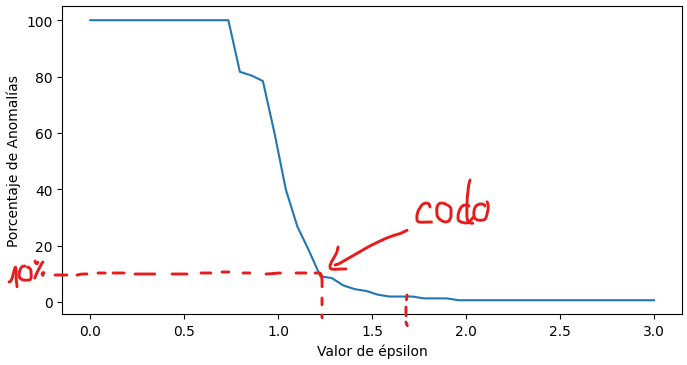

*Aplicamos una estimación tipo "codo" para valores por debajo del 10%, veamos para eps entre 1.25 (por ver bien el decrecimiento del porcentaje de anomalías) y 1.75 (este a ojo)*

Voy a entrenar un modelo con eps=1.25, que es justo en el codo). 

Si no fuera por el conocimiento de negocio que me han transmitido también hubiera aceptado eps=1.5, lo que resultaría en solo 2 clusters + el de anomalías.

In [9]:
# fit DBSCAN with eps=1.2 y min_samples=10
eps = 1.20
min_samples = 2*train_set.shape[1]

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(train_set)

DBSCAN(eps=1.2, min_samples=10)

Agregar las etiquetas generadas con DBSCAN a tu dataframe original e interpreta los resultados (observa el número de etiquetas, recuerda que -1 no es un cluster son anomalías o outliers)

In [10]:
train_set['Labels_DBSCAN'] = dbscan.labels_
train_set['Labels_DBSCAN'].value_counts()

Labels_DBSCAN
 0    51
 1    49
 2    31
-1    22
Name: count, dtype: int64

Ha encontrado 3 clusters o agrupaciones, y un último de anomalias (sin clusterizar). Que podemos asociar a la captura y grupos que yo he encontrado a ojo,

In [11]:
train_set.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Labels_DBSCAN
0,1.518613,0.232053,1.034819,1.013009,0.251717,0
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,0
2,0.196879,1.109334,1.215533,1.395148,0.269020,0
3,1.691550,0.487926,1.466525,2.334574,1.186068,0
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,-1


Si vemos un poco los resultados (porque todos son numéricas). Veamos que ha pasado con las agrupaciones.


In [12]:
# Valor medio de los parámetros según la clusterización de DBSCAN
pd.DataFrame(train_set.groupby(['Labels_DBSCAN']).mean())

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
Labels_DBSCAN,,,,,
-1,0.011589,0.079193,0.192856,0.063596,0.046246
0,0.942640,0.322361,0.951155,1.135081,0.189461
1,-1.048470,-0.279695,-0.065242,-0.785515,-0.944648
2,0.193152,0.039524,-1.395908,-0.275957,0.931047


- Clase 0: tiene todos los parámetros más altos (de media), a excepción de la taurina que tiene un valor más moderado. Parece que tendrán buen sabor (por los ácidos cítricos), y poder energizante alto, pero sin aumentar redimiento cognitivo o deportivo (baja taurina).

- Cluster 1: Este grupo agrupa productos que podrían ser más naturales o saludables, con bajos niveles en todas las propiedades analizadas.

- Cluster 2: Este cluster parece centrarse en productos que contienen mucha taurina pero con niveles muy bajos de cafeína. Podría representar un tipo de bebida energética baja en cafeína pero rica en taurina. Mejorar la concentración pero sin aumetar el nerviosismo.

### Aproximación aglomerativa.

El segundo clustering que voy a emplear es jerárquico por `aproximación aglomerativa (AHC)`. Vamos a emplear una clusterización jerárquica porque sea cual sea la agrupación sí que nos interesa establecer una jerarquía o una relación de distancia entre las diferentes propiedades químicas.

Voy a emplear el mismo set que antes.

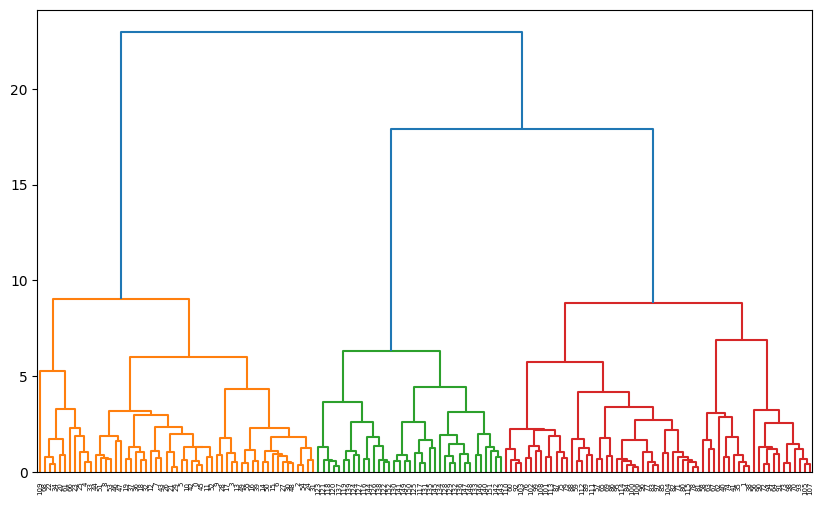

In [13]:
# Dejo las etiquetas del DBSCAN fuera pero el set es el mismo
features = ['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']

# Linkage method
link_method = shc.linkage(train_set[features], method='ward', metric='euclidean')

# Dendrograma
plt.figure(figsize =(10, 6))
shc.dendrogram(Z=link_method)
plt.show()

Con la técnica del máximo gap horizontal (y la ayuda de los colores), vemos que `el dendrograma también propone 3 clusters`.

Vamos a ver cuántos elementos tiene cada cluster

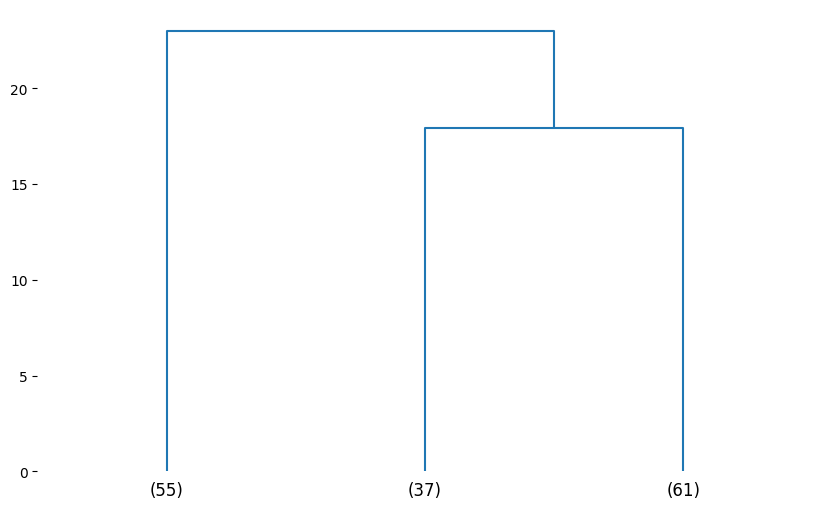

In [14]:
# Crear el cluster jerárquico
n_clusters = 3

# Miramos cuantos elementos hay en cada cluster
plt.figure(figsize =(10, 6))
dend = shc.dendrogram(Z=link_method,
                 truncate_mode='lastp',
                 p=n_clusters
                 )
sns.despine(left=True, bottom=True)

Ahora podemos crear nuestro modelo de agrupamiento jerárquico aglomerativo utilizando AgglomerativeClustering de Scikit-Learn y averiguar las etiquetas de los puntos de marketing con labels_:

In [15]:
# Instanciar AgglomerativeClustering y entrenar modelo
n_clusters = 3
ahc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')

ahc.fit(train_set[features])


AgglomerativeClustering(n_clusters=3)

In [16]:
# Frecuencia de elementos en cada cluster
train_set['AHC'] = ahc.labels_
train_set.AHC.value_counts()

AHC
1    61
0    55
2    37
Name: count, dtype: int64

In [17]:
train_set.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Labels_DBSCAN,AHC
0,1.518613,0.232053,1.034819,1.013009,0.251717,0,0
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,0,1
2,0.196879,1.109334,1.215533,1.395148,0.269020,0,0
3,1.691550,0.487926,1.466525,2.334574,1.186068,0,0
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,-1,0


In [18]:
# Valor medio de los parámetros según la clusterización de AHC
df_result_AHC = pd.DataFrame(train_set.drop(columns='Labels_DBSCAN').groupby(['AHC']).mean())
display(df_result_AHC)

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
AHC,,,,,
0,0.891996,0.520492,1.020946,1.102175,0.230639
1,-0.873346,-0.491226,0.021142,-0.609412,-0.884453
2,0.193422,0.190284,-1.382700,-0.302761,0.933003


Las conclusiones de los tres tipos de grupo que tengo son un poco similares a las anteriores.

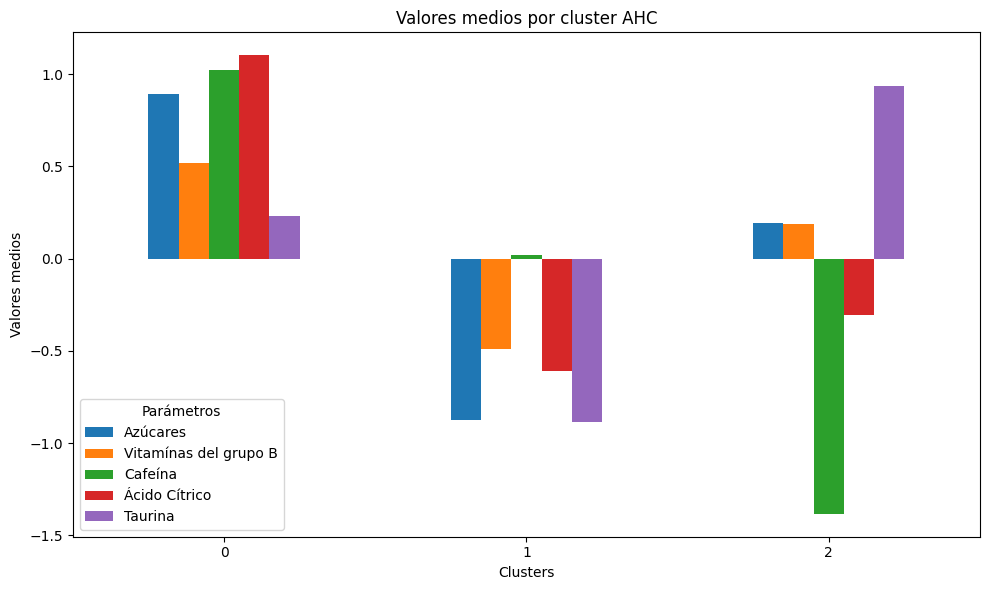

In [19]:
df_result_AHC.plot(kind='bar', figsize=(10, 6))
# Etiquetas y título
plt.title('Valores medios por cluster AHC')
plt.xlabel('Clusters')
plt.ylabel('Valores medios')
plt.xticks(rotation=0)
plt.legend(title='Parámetros')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

Ahora que tenemos un set etiquetado (y que negocio le ha dado el visot bueno), podríamos emplearlo para entrenar modelos supervisados.


In [20]:
# Ya están estandarizados. No voy a hacer ninguna transformación
X_new = pd.read_csv('./data/new_experiments.csv', sep='|')

### Predicción con DBSCAN

El algoritmo DBSCAN no tiene un método explícito para hacer predicciones en nuevos datos (no es un modelo supervisado). Sin embargo, se puede utilizar el vecino más cercano o una distancia mínima para clasificar nuevos puntos o asignar el valor de "ruido" si no pertenecen claramente a ninguno de los clusters ya definidos.

Como todo está estandarizado ya y hemos empleado técnicas basadas en distancias, voy a usar un KNN para el modelo predictor.

Como puedo ver la distribución de etiquetas, voy a emplear el hiperparámetro de KNN con algo de conocimiento (aunque se podría optimizar con GridSearch)

In [21]:
train_set['Labels_DBSCAN'].value_counts()

Labels_DBSCAN
 0    51
 1    49
 2    31
-1    22
Name: count, dtype: int64

In [22]:
train_set['Labels_DBSCAN'].nunique()

4

In [23]:
len(train_set['Labels_DBSCAN']) // train_set['Labels_DBSCAN'].nunique()

38

In [24]:
# No tiene .predict. Ya están los datos etiquetados y se le deja al usuario 
# predecir con el algoritmo de clasificacion que prefiera. Por ejemplo, KNN.
n_neighbors = len(train_set['Labels_DBSCAN']) // train_set['Labels_DBSCAN'].nunique()
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fijate que se entrena con las instancias core, no con todas las instancias (aunque podríamos hacerlo con todas)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_]) 


KNeighborsClassifier(n_neighbors=38)

Ten en cuenta que solo entrenamos al clasificador en las instancias core, pero también podríamos haber elegido entrenarlo en todas las instancias, o en todas menos en las anomalías: esta elección depende de la tarea final. 

Y ahora podemos`hacer predicciones/etiquetar nuevas instancias no icluidas en el dataset inicial:

In [25]:
# Las predicciones
pred_knn = knn.predict(X_new)
pred_knn

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 1, 1, 1, 0], dtype=int64)

In [26]:
pred_proba_knn = knn.predict_proba(X_new)
pred_proba_knn

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


array([[0.81578947, 0.        , 0.18421053],
       [0.81578947, 0.18421053, 0.        ],
       [0.07894737, 0.78947368, 0.13157895],
       [0.        , 0.78947368, 0.21052632],
       [0.02631579, 0.68421053, 0.28947368],
       [0.55263158, 0.15789474, 0.28947368]])

### Predicción con AHC

Ya tenemos instanciado el modelo. Con el método fit_predict, nos devuelve directamente los valores de los clusters asociados:


In [27]:
# Fit and return the result of each sample’s clustering assignment.
pred_ahc = ahc.fit_predict(X_new)
pred_ahc

array([1, 1, 0, 0, 0, 2], dtype=int64)

Cada modelo hace una clusterización diferente pero ambas posibles.

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

`NOTA`: No tienen la misma longitud, así que he cortado el fichero para que tenga el mismo número de filas.

In [28]:
# Leer el fichero de resultados
df_power_results = pd.read_csv('./data/power_results.csv')

# Concatenarlo con las predicciones anteriores
train_set = pd.concat([train_set, df_power_results], axis=1)
train_set.rename(columns={'class': 'power_result'}, inplace=True)
train_set.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Labels_DBSCAN,AHC,power_result
0,1.518613,0.232053,1.034819,1.013009,0.251717,0,0,1
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,0,1,1
2,0.196879,1.109334,1.215533,1.395148,0.269020,0,0,1
3,1.691550,0.487926,1.466525,2.334574,1.186068,0,0,1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,-1,0,1


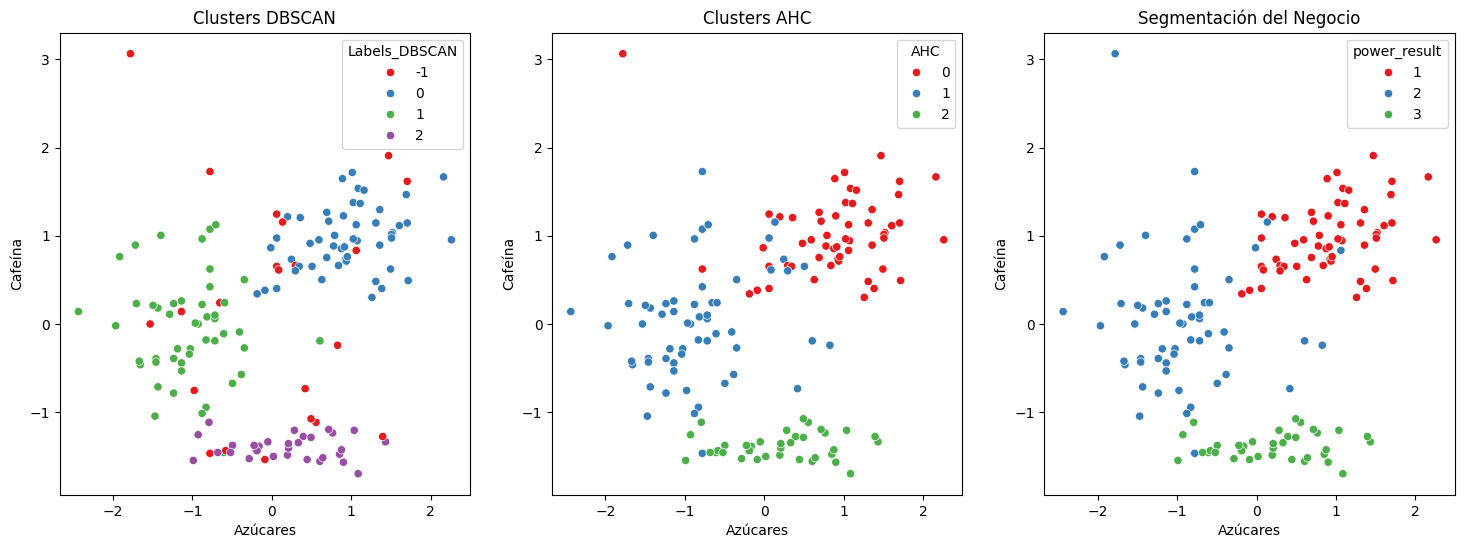

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Visualización de DBSCAN
sns.scatterplot(data=train_set, x='Azúcares', y='Cafeína', hue='Labels_DBSCAN', palette='Set1', ax=axs[0])
axs[0].set_title('Clusters DBSCAN')

# Visualización de AHC
sns.scatterplot(data=train_set, x='Azúcares', y='Cafeína', hue='AHC', palette='Set1', ax=axs[1])
axs[1].set_title('Clusters AHC')

# Visualización de la segmentación del negocio
sns.scatterplot(data=train_set, x='Azúcares', y='Cafeína', hue='power_result', palette='Set1', ax=axs[2])
axs[2].set_title('Segmentación del Negocio')

plt.show()


De esta gráfic que hemos limitado a dos features puedo observar que:
- Clase 0 de DBSCAN, es similar a clase 0 de AHC, e igual a clase 1 de la segmentación de negocio.

Dado que los números de cluster son diferentes, se puede crear una matriz de confusión para observar cómo se asignan los clusters de tus modelos a los grupos de la segmentación del negocio. Así queda de una forma numérica un poco más elegante.

In [35]:
train_set['power_result'].unique()

array([1, 2, 3], dtype=int64)

In [43]:
# Agrupar por labels y calcular la media para las características
mean_dbscan = train_set.drop(columns=['AHC', 'power_result']).groupby('Labels_DBSCAN').mean()
mean_ahc = train_set.drop(columns=['Labels_DBSCAN', 'power_result']).groupby('AHC').mean()
mean_class = train_set.drop(columns=['AHC', 'Labels_DBSCAN']).groupby('power_result').mean()

print("Promedio por cluster DBSCAN:")
display(mean_dbscan)

print("\nPromedio por cluster AHC:")
display(mean_ahc)

print("\nPromedio por cluster del Negocio:")
display(mean_class)


Promedio por cluster DBSCAN:


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
Labels_DBSCAN,,,,,
-1,0.011589,0.079193,0.192856,0.063596,0.046246
0,0.942640,0.322361,0.951155,1.135081,0.189461
1,-1.048470,-0.279695,-0.065242,-0.785515,-0.944648
2,0.193152,0.039524,-1.395908,-0.275957,0.931047



Promedio por cluster AHC:


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
AHC,,,,,
0,0.891996,0.520492,1.020946,1.102175,0.230639
1,-0.873346,-0.491226,0.021142,-0.609412,-0.884453
2,0.193422,0.190284,-1.382700,-0.302761,0.933003



Promedio por cluster del Negocio:


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
power_result,,,,,
1,0.924362,0.336491,0.970458,1.161258,0.221669
2,-0.932977,-0.336353,0.051601,-0.693084,-0.894666
3,0.193422,0.190284,-1.382700,-0.302761,0.933003
